<a href="https://colab.research.google.com/github/Valeri22222/Ecosystem-monitoring-through-IT-solutions/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **«Мониторинг экосистемы через IT-решения»**

### **Оценка эффективности предобученной модели для классификации изображений на наличие лесных пожаров**

####   Задачи:
1. Загрузить модель.
2. Загрузить и подготовить датасет.
3. Применить модель для предсказаний.
4. Оценить качество модели с использованием метрик и статистических методов.
5. Провести бизнес-анализ матрицы ошибок.

### Импорт необходимых библиотек для проекта

In [2]:
# системные библиотеки
import os
import sys
import warnings
warnings.filterwarnings('ignore')  # Отключаем предупреждения для чистоты вывода

# работа с файлами и путями
from pathlib import Path

# обработка данных
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# обработка изображений
from PIL import Image

# визуализация
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
sns.set(style="whitegrid")

### Загрузка модели

### **О модели vit-fire-detection:**

**Основа:** google/vit-base-patch16-224-in21k

Vision Transformer (ViT) - это архитектура для обработки изображений, которая:
- Разбивает изображение на блоки 16x16 пикселей (патчи)
- Преобразует их в последовательность векторов
- Обрабатывает с помощью механизма внимания (attention)
- Позволяет модели анализировать глобальные связи в изображении

####**Требования к входным данным**

 Формат и размер изображений:

-    Размер: 224×224 пикселей

 -   Соотношение сторон: 1:1 (квадрат)

-    Цветовая модель: RGB (3 канала)

 -   Форма данных для модели: (batch_size, 3, 224, 224)

In [3]:
!pip install -U transformers

# Импорт библиотек для работы с моделью
from transformers import pipeline

model = pipeline("image-classification", model="EdBianchi/vit-fire-detection")

config.json:   0%|          | 0.00/757 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/343M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/325 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cpu


### Загрузка датасета

Название: Wildfire Detection Dataset

Автор: busier

Платформа: Kaggle

Ссылка: https://www.kaggle.com/datasets/busier/wildfire


In [4]:
# Установка необходимых пакетов
!pip install kagglehub
import kagglehub

In [5]:
# Скачиваем последнюю версию датасета с кагл
path = kagglehub.dataset_download("busier/wildfire")

Using Colab cache for faster access to the 'wildfire' dataset.


### Чтение данных и формирование датафрейма

In [6]:
# Создаем DataFrame
data = []
for root, dirs, files in os.walk(path):
  for file in files:
    if file.lower().endswith(('.jpg', '.jpeg')):
      full_path = os.path.join(root, file)

      data.append({
          'path': full_path,
           'filename': file,
            'class': os.path.basename(root).lower()
            })

df = pd.DataFrame(data)

In [7]:
df.head(10)

,path,filename,class
0,/kaggle/input/wildfire/Dataset/Valid/NoFire/no...,no_fire4037.jpg,nofire
1,/kaggle/input/wildfire/Dataset/Valid/NoFire/no...,no_fire4961.jpg,nofire
2,/kaggle/input/wildfire/Dataset/Valid/NoFire/no...,no_fire5662.jpg,nofire
3,/kaggle/input/wildfire/Dataset/Valid/NoFire/no...,no_fire4431.jpg,nofire
4,/kaggle/input/wildfire/Dataset/Valid/NoFire/no...,no_fire3227.jpg,nofire
5,/kaggle/input/wildfire/Dataset/Valid/NoFire/no...,no_fire3022.jpg,nofire
6,/kaggle/input/wildfire/Dataset/Valid/NoFire/no...,no_fire4032.jpg,nofire
7,/kaggle/input/wildfire/Dataset/Valid/NoFire/no...,no_fire668.jpg,nofire
8,/kaggle/input/wildfire/Dataset/Valid/NoFire/no...,no_fire1487.jpg,nofire
9,/kaggle/input/wildfire/Dataset/Valid/NoFire/no...,no_fire840.jpg,nofire


In [8]:
df['class'].value_counts()

,count
class,
nofire,7189
fire,6874


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14063 entries, 0 to 14062
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   path      14063 non-null  object
 1   filename  14063 non-null  object
 2   class     14063 non-null  object
dtypes: object(3)
memory usage: 329.7+ KB


### Формируем случайную выборку из загруженных данных

In [10]:
sample_size = 2000  # размер выборки
random_seed = 42

# Балансируем выборку по классам
fire_df = df[df['class'] == 'fire']
notfire_df = df[df['class'] == 'nofire']

# Берем поровну от каждого класса
n_per_class = min(sample_size // 2, len(fire_df), len(notfire_df))

if n_per_class > 0:
    fire_sample = fire_df.sample(n_per_class, random_state=random_seed)
    notfire_sample = notfire_df.sample(n_per_class, random_state=random_seed)
    test_df = pd.concat([fire_sample, notfire_sample]).reset_index(drop=True)
else:
    # Если один из классов отсутствует, берем случайную выборку
    test_df = df.sample(min(sample_size, len(df)), random_state=random_seed)

print(f"Выборка для тестирования: {len(test_df)} изображений")
print(f"  Fire: {len(test_df[test_df['class']=='fire'])}")
print(f"  Notfire: {len(test_df[test_df['class']=='nofire'])}")

Выборка для тестирования: 2000 изображений
  Fire: 1000
  Notfire: 1000


###Предсказание для всех изображений в выборке

In [11]:
def predict_image(model, image_path):
    """Предсказывает класс изображения (пожар/нет пожара) с помощью предобученной модели.

    Args:
        model: Загруженная модель для классификации изображений.
        image_path (str): Путь к файлу изображения.

    Returns:
        dict: Словарь с предсказанной меткой ('predicted_label') и вероятностью ('predicted_score'),
              или None в случае ошибки обработки изображения.
    """
    try:
        image = Image.open(image_path).convert('RGB')
        predictions = model(image)

        # Берем предсказание с наивысшей вероятностью
        top_prediction = predictions[0]
        label = top_prediction['label'].lower()
        score = top_prediction['score']

        return {
            'predicted_label': label,
            'predicted_score': score
        }
    except Exception as e:
        print(f"Ошибка при обработке {image_path}: {e}")
        return None


# Прогнозируем для всех изображений в выборке
results = []

for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Обработка изображений"):
    result = predict_image(model, row['path'])

    if result['predicted_label'] == 'normal':
        results.append({
            'predicted_label': 'nofire',
            'predicted_score': result['predicted_score']
       })
    else:
        results.append({
            'predicted_label': 'fire',
            'predicted_score': result['predicted_score']
       })


# Добавляем результаты в DataFrame
test_df = test_df.copy()
test_df = pd.concat([test_df, pd.DataFrame(results)], axis=1)

test_df.head(10)

Обработка изображений: 100%|██████████| 2000/2000 [28:38<00:00,  1.16it/s]


,path,filename,class,predicted_label,predicted_score
0,/kaggle/input/wildfire/Dataset/Train/Fire/Fire...,Fire2650.jpg,fire,fire,0.998470
1,/kaggle/input/wildfire/Dataset/Train/Fire/Fire...,Fire3577.jpg,fire,fire,0.998816
2,/kaggle/input/wildfire/Dataset/Train/Fire/Fire...,Fire4413.jpg,fire,fire,0.998803
3,/kaggle/input/wildfire/Dataset/Train/Fire/Fire...,Fire2535.jpg,fire,fire,0.998771
4,/kaggle/input/wildfire/Dataset/Train/Fire/Fire...,Fire5208.jpg,fire,fire,0.998830
5,/kaggle/input/wildfire/Dataset/Train/Fire/Fire...,Fire4410.jpg,fire,fire,0.993346
6,/kaggle/input/wildfire/Dataset/Train/Fire/Fire...,Fire4666.jpg,fire,fire,0.998694
7,/kaggle/input/wildfire/Dataset/Train/Fire/Fire...,Fire3484.jpg,fire,fire,0.998321
8,/kaggle/input/wildfire/Dataset/Train/Fire/Fire...,Fire3424.jpg,fire,fire,0.998803
9,/kaggle/input/wildfire/Dataset/Test/Fire/Fire2...,Fire284.jpg,fire,fire,0.998747


## Оценка качества модели

In [12]:
# Преобразуем test_df для метрик
y_true = test_df['class']
y_pred = test_df['predicted_label']

# Расчет общей точности
accuracy = accuracy_score(y_true, y_pred)
print(f"Общая точность модели: {accuracy:.2f}")

# Отчет по классификации (precision, recall, f1-score)
print("\nОтчет по классификации:")
print(classification_report(y_true, y_pred, target_names=['notfire', 'fire']))


Общая точность модели: 0.90

Отчет по классификации:
              precision    recall  f1-score   support

     notfire       0.93      0.87      0.90      1000
        fire       0.87      0.94      0.90      1000

    accuracy                           0.90      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.90      0.90      0.90      2000



### `requirements.txt`

Этот файл содержит список всех Python-библиотек, используемых в проекте, для обеспечения воспроизводимости среды.

Для установки всех зависимостей из этого файла используйте команду:
`pip install -r requirements.txt`

In [ ]:
%%writefile requirements.txt
pandas
numpy
scipy
scikit-learn
Pillow
matplotlib
tqdm
seaborn
transformers
kagglehub

### Интерпретация точности модели
Точность 90% означает, что модель правильно классифицирует 90 из 100 изображений.
Для задачи детекции пожаров это хороший результат, но требует анализа ошибок:
- False Positive (ложные срабатывания) могут приводить к неоправданным затратам.
- False Negative (пропущенные пожары) недопустимы из-за риска для жизни и имущества.

### Оценка качества модели с помощью расчета доверительного интервала Метод Уилсона

Метод Уилсона (интервал Уилсона со счетом) используется для оценки точности модели.
Формула Нижняя $(LB$) и верхняя ($UB)$ границы доверительного интервала рассчитываются так:

$\frac{1}{1+\frac{z^{2}}{n}}\left(p+\frac{z^{2}}{2n}\pm z\sqrt{\frac{p(1-^{p})}{n}+\frac{z^{2}}{4n^{2}}}\right)$

Где:

p — наблюдаемая точность модели (Accuracy).

n — размер выборки.

z — квантиль нормального распределения для выбранного уровня доверия.

In [13]:
n = len(test_df)  # размер выборки

def wilson_interval(p_mean, n, confidence_level=0.95):

    """Расчет доверительного интервала Уилсона для точности модели

    Args:
        p_mean (float): Наблюдаемая точность модели.
        n (int): Общий размер выборки.
        confidence_level (float, optional): Уровень доверия для интервала.
                                            По умолчанию 0.95.

    Returns:
        tuple: Кортеж, содержащий нижнюю границу интервала, верхнюю границу интервала,
               значение Z-квантиля и значение погрешности (margin).
    """

    z = stats.norm.ppf((1 + confidence_level) / 2)

    denominator = 1 + z**2 / n
    center = (p_mean + z**2 / (2 * n)) / denominator
    margin = z * np.sqrt(p_mean * (1 - p_mean) / n + z**2 / (4 * n**2)) / denominator

    lower = center - margin
    upper = center + margin

    return lower, upper, z, margin


confidence_levels = [0.90, 0.95, 0.99]
results = {}

for cl in confidence_levels:
    lower, upper, z, margin = wilson_interval(accuracy, n, cl)
    results[cl] = (lower, upper, z, margin)

    print(f"\nУровень доверия для {cl} (Z = {z:.3f}):")
    print(f"Доверительный интервал: [{lower:.4f}, {upper:.4f}]")


Уровень доверия для 0.9 (Z = 1.645):
Доверительный интервал: [0.8889, 0.9110]

Уровень доверия для 0.95 (Z = 1.960):
Доверительный интервал: [0.8866, 0.9129]

Уровень доверия для 0.99 (Z = 2.576):
Доверительный интервал: [0.8819, 0.9164]


#### Ключевые наблюдения и выводы:

-    Высокая точность: Все интервалы группируются вокруг значения 90%, что указывает на эффективность модели.

-    Стабильность оценки: Даже при 99% доверии интервал имеет ширину менее 3.5% (от 88.2% до 91.6%). Это говорит о том, что оценка точности надежна и не является результатом случайного колебания на маленькой выборке.



##Статистическая значимость

Мы формулируем две гипотезы:

**Нулевая гипотеза (H0)**: Точность модели случайна. Модель работает на уровне случайного угадывания. Все отклонения от этого значения вызваны случайным шумом. Так как выборка 50/50 p0 = 0.5

**Альтернативная гипотеза (H1)**: Точность модели статистически значимо отличается от случайного угадывания.

In [14]:
# Нулевая гипотеза: p = 0.5 (случайное угадывание)
p0 = 0.5

# Z-статистика для проверки гипотезы
z_stat = (accuracy - p0) / np.sqrt(p0 * (1 - p0) / n)
p_value = 2 * (1 - stats.norm.cdf(abs(z_stat)))

print(f"Z-статистика: {z_stat:.4f}")
print(f"P-значение: {p_value:.6f}")

if p_value < 0.05:
    print(f"✅ Результат статистически значим (p < 0.05)")
    print(f"Модель работает лучше случайного угадывания")
else:
    print(f"❌ Результат не статистически значим (p ≥ 0.05)")
    print(f"Нет оснований считать, что модель лучше случайного угадывания")

Z-статистика: 35.8218
P-значение: 0.000000
✅ Результат статистически значим (p < 0.05)
Модель работает лучше случайного угадывания


###Расчет необходимого размера выборки

Данный метод позволяет определить минимальное количество объектов n, необходимое для того, чтобы оценка точности модели отклонялась от истинной величины не более чем на заданную погрешность с выбранным уровнем доверия (обычно 95%).

Расчет базируется на формуле для доверительного интервала доли:

$n=\frac{Z^{2}\cdot {p}(1-{p})}{E^{2}}$

Где:
Z — квантиль нормального распределения;

p — ожидаемая или текущая точность модели;

E — допустимая погрешность.


In [15]:
def calculate_required_sample_size(p_hat, margin_of_error=0.05, confidence_level=0.95):
    """
    Расчет минимального размера выборки, необходимого для оценки точности с заданной погрешностью
    и уровнем доверия.

    Args:
        p_hat (float): Ожидаемая или текущая точность модели.
        margin_of_error (float, optional): Желаемая допустимая погрешность.
                                            По умолчанию 0.05.
        confidence_level (float, optional): Уровень доверия для интервала.
                                            По умолчанию 0.95.

    Returns:
        int: Минимальное количество объектов (размер выборки) для обеспечения заданных параметров.
    """

    z = stats.norm.ppf((1 + confidence_level) / 2)

    # Формула для размера выборки
    n_required = (z**2 * p_hat * (1 - p_hat)) / (margin_of_error**2)

    return int(np.ceil(n_required))

# Для разных уровней погрешности
margins = [0.01, 0.02, 0.03, 0.05, 0.10]
print(f"   Для точности {accuracy:.2%}:")

for margin in margins:
    n_req = calculate_required_sample_size(accuracy, margin)
    print(f"   • Для погрешности ±{margin:.2f}: n ≥ {n_req} изображений")

   Для точности 90.05%:
   • Для погрешности ±0.01: n ≥ 3442 изображений
   • Для погрешности ±0.02: n ≥ 861 изображений
   • Для погрешности ±0.03: n ≥ 383 изображений
   • Для погрешности ±0.05: n ≥ 138 изображений
   • Для погрешности ±0.10: n ≥ 35 изображений


##Визуализация данных для упрощения интерпретации результатов и поддержки принятия решений

###Матрица ошибок: анализ производительности модели

Матрица ошибок (Confusion Matrix) — это таблица, которая наглядно показывает, как модель классификации справляется с различными классами. Для нашей задачи бинарной классификации (обнаружение пожара) матрица будет иметь размер 2×2 и включать четыре категории:

 -   TN (True Negative) - правильно идентифицированные изображения без пожара

 -   FP (False Positive) - изображения без пожара, ошибочно принятые за пожар (ложная тревога)

 -   FN (False Negative) - изображения с пожаром, которые модель пропустила (опасная ошибка!)

 -   TP (True Positive) - правильно обнаруженные пожары

 Эта визуализация поможет понять, насколько надежна модель в реальных условиях и какие типы ошибок требуют особого внимания.

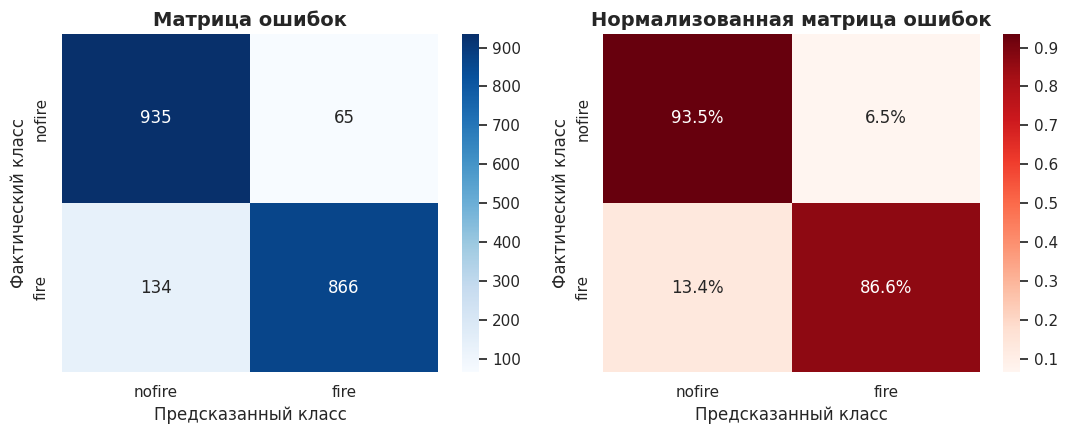

Интерпретация матрицы ошибок:
   Правильно классифицировано 'notfire': 935 из 1000.0 (93.5%)
   Правильно классифицировано 'fire': 866 из 1000.0 (86.6%)
   Ошибки типа I (False Positive): 65 изображений
   Ошибки типа II (False Negative): 134 изображений


In [16]:
# Вычисляем матрицу ошибок
cm = confusion_matrix(test_df['class'], test_df['predicted_label'], labels=['nofire', 'fire'])

fig, axes = plt.subplots(1, 2, figsize=(11, 4.5))

# График 1: Тепловая карта матрицы ошибок
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['nofire', 'fire'],
            yticklabels=['nofire', 'fire'],
            ax=axes[0])
axes[0].set_title('Матрица ошибок', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Предсказанный класс', fontsize=12)
axes[0].set_ylabel('Фактический класс', fontsize=12)

# График 2: Нормализованная матрица ошибок
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.1%', cmap='Reds',
            xticklabels=['nofire', 'fire'],
            yticklabels=['nofire', 'fire'],
            ax=axes[1])
axes[1].set_title('Нормализованная матрица ошибок', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Предсказанный класс', fontsize=12)
axes[1].set_ylabel('Фактический класс', fontsize=12)

plt.tight_layout()
plt.show()

print("Интерпретация матрицы ошибок:")
print(f"   Правильно классифицировано 'notfire': {cm[0,0]} из {len(test_df)/2} ({(cm[0,0]/(len(test_df)/2)*100)}%)")
print(f"   Правильно классифицировано 'fire': {cm[1,1]} из {len(test_df)/2} ({(cm[1,1]/(len(test_df)/2)*100)}%)")
print(f"   Ошибки типа I (False Positive): {cm[0,1]} изображений")
print(f"   Ошибки типа II (False Negative): {cm[1,0]} изображений")

### Краткий вывод по результатам матрицы ошибок

Модель показывает сбалансированную и высокую эффективность в обеих задачах классификации

### Распределение ошибок:

-    Ошибки типа I (False Positive, 65 случаев): Ситуации "ложной тревоги" — модель иногда принимает безопасные объекты за пожар.

-    Ошибки типа II (False Negative, 134 случая): Более серьёзные ошибки — пропуск реального пожара.


#### В контексте пожарной безопасности ошибки типа II (пропуск пожара) потенциально опаснее ошибок типа I (ложная тревога).

##Бизнес-анализ: стоимостные последствия ошибок модели

Наш анализ переходит от технических метрик к реальным бизнес-последствиям. Мы присваиваем гипотетические денежные значения разным типам ошибок модели:

###Ложная тревога (False Positive): 10,000 USD

-   Оперативные расходы на эвакуацию
 -   Вызов пожарных бригад
  -   Простой производства/бизнеса
 -   Репутационные издержки


###Пропущенный пожар (False Negative): 500,000 USD

-   Материальный ущерб от пожара
-   Восстановительные работы
 -   Юридические последствия
 -   Возможные человеческие жертвы
-   Экологический ущерб


###1 пропущенный пожар = 50 ложных тревог:
-    Ложная тревога = временные неудобства
-    Пропущенная угроза = катастрофические последствия

Анализ стоимостных последствий ошибок:
   • Стоимость ложной тревоги (False Positive): $650,000
   • Стоимость пропущенного пожара (False Negative): $67,000,000
   • Общая потенциальная стоимость ошибок: $67,650,000


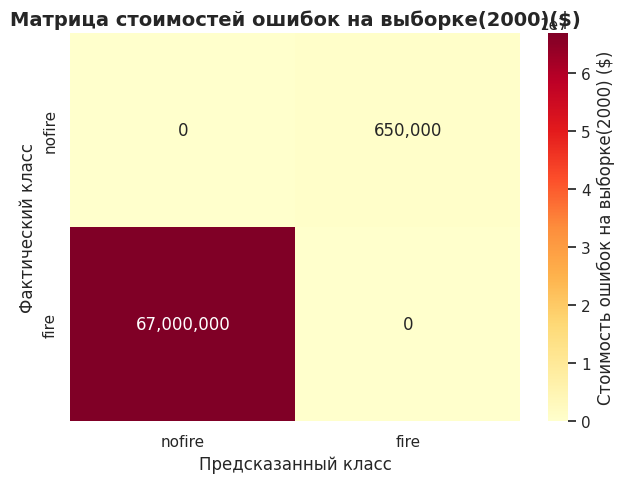

In [17]:
# Добавляем стоимость ошибок (гипотетические значения)
cost_false_positive = 10000  # Стоимость ложной тревоги (эвакуация, ложный вызов)
cost_false_negative = 500000  # Стоимость пропущенного пожара (ущерб, жизни)
cost_correct = 0  # Правильное определение

# Вычисляем общую стоимость ошибок
total_cost = (cm[0,1] * cost_false_positive +  # False Positives
              cm[1,0] * cost_false_negative +  # False Negatives
              (cm[0,0] + cm[1,1]) * cost_correct)  # Correct classifications

print(f"Анализ стоимостных последствий ошибок:")
print(f"   • Стоимость ложной тревоги (False Positive): ${cm[0,1] * cost_false_positive:,}")
print(f"   • Стоимость пропущенного пожара (False Negative): ${cm[1,0] * cost_false_negative:,}")
print(f"   • Общая потенциальная стоимость ошибок: ${total_cost:,.0f}")

# Создаем тепловую карту стоимости
cost_matrix = np.array([
    [0, cm[0,1] * cost_false_positive],
    [cm[1,0] * cost_false_negative, 0]
])

fig, axes = plt.subplots(1, 1, figsize=(6.5, 5))

# График 3: Матрица стоимостей
sns.heatmap(cost_matrix, annot=True, fmt=',.0f', cmap='YlOrRd',
            xticklabels=['nofire', 'fire'],
            yticklabels=['nofire', 'fire'],
            ax=axes,
            cbar_kws={'label': f'Стоимость ошибок на выборке({len(test_df)}) ($)'})
axes.set_title(f'Матрица стоимостей ошибок на выборке({len(test_df)})($)', fontsize=14, fontweight='bold')
axes.set_xlabel('Предсказанный класс', fontsize=12)
axes.set_ylabel('Фактический класс', fontsize=12)

plt.tight_layout()
plt.show()

###Анализ уверенности предсказаний

В этом разделе проведен стратегический анализ того, как порог классификации влияет на эффективность модели обнаружения пожаров.

Мы найдем баланс между техническими метриками и экономическими последствиями ошибок.

###Из чего состоит анализ:

####Диапазон порогов: От 0.3 до 0.9 с шагом 0.05

####Технические метрики для каждого порога:

-    Precision (Точность): Насколько мы можем доверять предупреждениям

-    Recall (Полнота): Сколько реальных пожаров мы ловим

-    F1-score: Баланс между точностью и полнотой

####Экономические последствия:

-   Общая стоимость ошибок (ложные тревоги + пропущенные пожары)

-   Оптимизация с учетом разной цены ошибок

###Критерии выбора оптимального порога
####Критерий A: Максимальный F1-score

 -   Лучший технический баланс

-    НО: Не учитывает, что пропущенный пожар опаснее ложной тревоги

####Критерий B: Минимальная стоимость ошибок

 -   Бизнес-ориентированный подход

-    Учитывает, что ложная тревога стоит 10,000 USD, а пропушенный пожар 500,000 USD

In [18]:
# Анализ порогов
print("\n🔍 Анализ оптимальных порогов:")
thresholds = np.arange(0.3, 0.95, 0.05)
results = []

for threshold in thresholds:
    # Применяем порог для классификации: если predicted_score >= threshold, то 'fire', иначе 'nofire'
    test_df['adjusted_prediction'] = test_df['predicted_score'].apply(
        lambda x: 'fire' if x >= threshold else 'nofire'
    )

    # Вычисляем истинно положительные (TP), ложноположительные (FP) и ложноотрицательные (FN) случаи
    # Это необходимо для расчета Precision, Recall и стоимости ошибок.
    tp = ((test_df['class'] == 'fire') & (test_df['adjusted_prediction'] == 'fire')).sum()
    fp = ((test_df['class'] == 'nofire') & (test_df['adjusted_prediction'] == 'fire')).sum()
    fn = ((test_df['class'] == 'fire') & (test_df['adjusted_prediction'] == 'nofire')).sum()

    # Расчет Precision: TP / (TP + FP) - доля правильных положительных среди всех предсказанных положительных
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    # Расчет Recall: TP / (TP + FN) - доля правильных положительных среди всех фактических положительных
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    # Расчет F1-score: 2 * (Precision * Recall) / (Precision + Recall) - гармоническое среднее Precision и Recall
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Расчет общей стоимости ошибок для текущего порога
    # Используются гипотетические стоимости ложных срабатываний и пропущенных пожаров
    cost = fp * cost_false_positive + fn * cost_false_negative

    results.append({
        'threshold': threshold,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'cost': cost
    })

results_df = pd.DataFrame(results)

# Находим оптимальные пороги на основе F1-score (технический критерий) и стоимости (бизнес-критерий)
optimal_f1 = results_df.loc[results_df['f1'].idxmax()]
optimal_cost = results_df.loc[results_df['cost'].idxmin()]

print(f"   • Для максимального F1-score: порог = {optimal_f1['threshold']:.2f}")
print(f"     F1 = {optimal_f1['f1']:.3f}, Стоимость = ${optimal_f1['cost']:,.0f}")
print(f"   • Для минимальной стоимости: порог = {optimal_cost['threshold']:.2f}")
print(f"     F1 = {optimal_cost['f1']:.3f}, Стоимость = ${optimal_cost['cost']:,.0f}")


🔍 Анализ оптимальных порогов:
   • Для максимального F1-score: порог = 0.80
     F1 = 0.671, Стоимость = $16,540,000
   • Для минимальной стоимости: порог = 0.30
     F1 = 0.667, Стоимость = $10,000,000


Порог 0.30 является явно более выгодным с бизнес-точки зрения: он позволяет сэкономить $6.5 млн, пожертвовав минимальной долей в сбалансированной точности (F1 снижается всего на 0.004).

###Анализ конкретных ошибок

Переходим к детальному анализу отдельных ошибок модели:

-    Идентифицируем конкретные изображения, где модель ошибается

-    Анализируем паттерны ошибок по типам и уровням уверенности

-    Выявляем систематические проблемы в работе алгоритма


#### Типы критических ошибок:
-   False Positive (Ложная тревога)	Модель видит пожар там, где его нет
-   False Negative(Пропущенный пожар)	Модель не замечает реальный пожар


#### Методология анализа
1. Классификация ошибок по уровню уверенности

            Уровни уверенности модели:
            ▸ 0.60-0.70 — Слабая уверенность (модель сомневается)
            ▸ 0.70-0.80 — Средняя уверенность  
            ▸ 0.80-0.90 — Высокая уверенность
            ▸ 0.90-0.95 — Высокая уверенность
            ▸ 0.95-0.98 — Очень высокая уверенность (критические ошибки)
            ▸ 0.98-0.99 — Очень высокая уверенность (критические ошибки)
            ▸ 0.99-0.995 — Очень высокая уверенность (критические ошибки)
            ▸ 0.995-0.9985 — Очень высокая уверенность (критические ошибки)
            ▸ 0.9985-1.00 — Очень высокая уверенность (критические ошибки)
                


📊 Обнаружено 199 ошибок:
   • False Positive (ложные тревоги): 65
   • False Negative (пропущенные пожары): 134


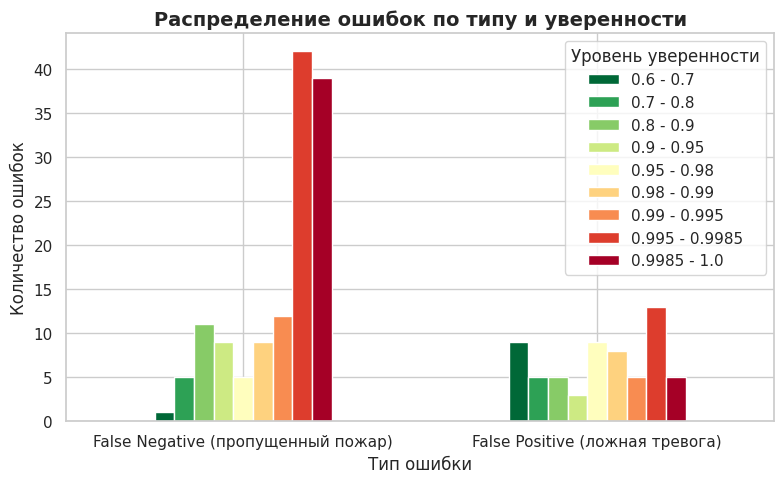


КРИТИЧЕСКИЕ ОШИБКИ (Уровень уверенности > 0.95) (147 случаев):


,filename,class,predicted_label,predicted_score,error_type
30,Fire5943.jpg,fire,nofire,0.983774,False Negative (пропущенный пожар)
36,Fire3888.jpg,fire,nofire,0.986800,False Negative (пропущенный пожар)
44,Fire6444.jpg,fire,nofire,0.998748,False Negative (пропущенный пожар)
49,Fire6293.jpg,fire,nofire,0.995046,False Negative (пропущенный пожар)
52,Fire4983.jpg,fire,nofire,0.998423,False Negative (пропущенный пожар)
...,...,...,...,...,...
1842,no_fire2728.jpg,nofire,fire,0.951588,False Positive (ложная тревога)
1899,Nofire395.jpg,nofire,fire,0.995173,False Positive (ложная тревога)
1945,no_fire6156.jpg,nofire,fire,0.962726,False Positive (ложная тревога)
1949,no_fire2307.jpg,nofire,fire,0.994982,False Positive (ложная тревога)


In [19]:
# Создаем подробный отчет об ошибках
errors_df = test_df[test_df['class'] != test_df['predicted_label']].copy()
errors_df['error_type'] = errors_df.apply(
    lambda row: 'False Positive (ложная тревога)' if row['class'] == 'nofire' else 'False Negative (пропущенный пожар)',
    axis=1
)

print(f"\n📊 Обнаружено {len(errors_df)} ошибок:")
print(f"   • False Positive (ложные тревоги): {len(errors_df[errors_df['error_type'] == 'False Positive (ложная тревога)'])}")
print(f"   • False Negative (пропущенные пожары): {len(errors_df[errors_df['error_type'] == 'False Negative (пропущенный пожар)'])}")

# Группируем ошибки по уровню уверенности
errors_df['confidence_level'] = pd.cut(errors_df['predicted_score'],
                                       bins=[0.6, 0.7, 0.8,  0.9, 0.95, 0.98, 0.99, 0.995, 0.9985, 1.0],
                                       labels=['0.6 - 0.7', '0.7 - 0.8',  '0.8 - 0.9', '0.9 - 0.95', '0.95 - 0.98',
                                               '0.98 - 0.99', '0.99 - 0.995', '0.995 - 0.9985', '0.9985 - 1.0'])

error_summary = errors_df.groupby(['error_type', 'confidence_level']).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(8, 5))
error_summary.plot(kind='bar', ax=ax, colormap='RdYlGn_r')
ax.set_title('Распределение ошибок по типу и уверенности', fontsize=14, fontweight='bold')
ax.set_xlabel('Тип ошибки', fontsize=12)
ax.set_ylabel('Количество ошибок', fontsize=12)
ax.legend(title='Уровень уверенности')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Выводим "проблемные" случаи (ошибки с высокой уверенностью)
problematic_errors = errors_df[errors_df['confidence_level'].isin(['0.95 - 0.98',
                                               '0.98 - 0.99', '0.99 - 0.995', '0.995 - 0.9985', '0.9985 - 1.0'])]
if len(problematic_errors) > 0:
    print(f"\nКРИТИЧЕСКИЕ ОШИБКИ (Уровень уверенности > 0.95) ({len(problematic_errors)} случаев):")
    display(problematic_errors[['filename', 'class', 'predicted_label', 'predicted_score', 'error_type']])

**Выявлена критическая проблема в работе модели: подавляющее большинство ошибок совершаются с крайне высокой уверенностью.**

Ключевые факты:

-    Всего допущено 199 ошибок (65 ложных тревог, 134 пропущенных пожара).

-    Почти половина всех ошибок (55+44=99 случаев, ~50%) совершена с аномально высокой уверенностью модели (> 0.995).

 -   Более 70% ошибок (55+44+17+17=133 случая) совершены с уверенностью свыше 0.98.



### Рассмотрим фото с критическими ошибками (Уровень уверенности > 0.95) False Negative (пропущенный пожар)

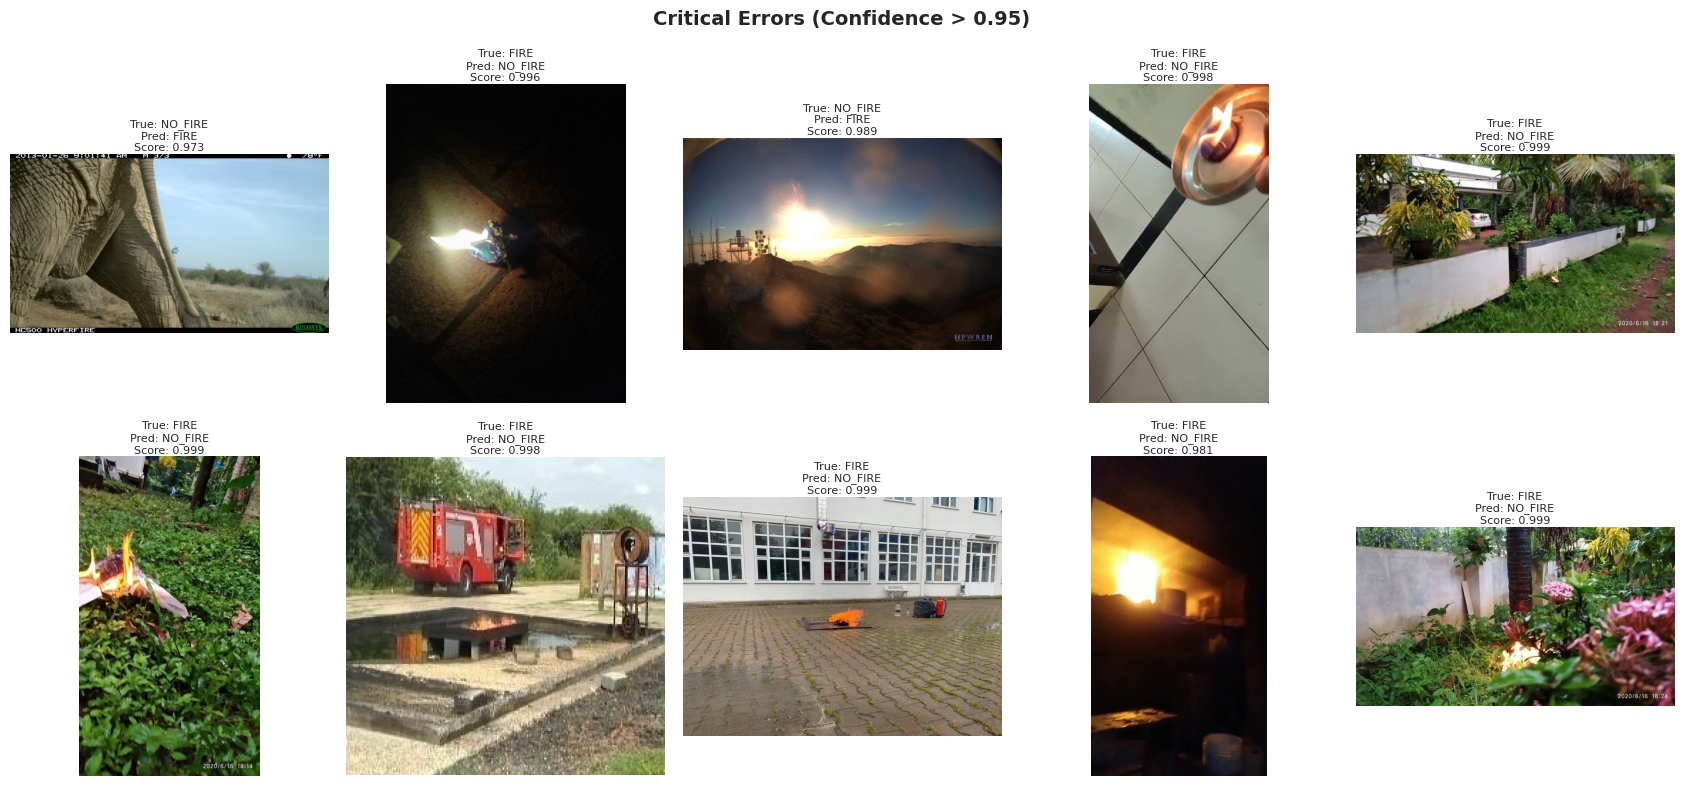

In [20]:
# Берем случайные 10 критических ошибок
problematic_samples = problematic_errors.sample(n=min(10, len(problematic_errors)), random_state=random_seed)

# Создаем сетку 2x5 для изображений
fig, axes = plt.subplots(2, 5, figsize=(17, 8))
axes = axes.ravel()

for idx, (_, row) in enumerate(problematic_samples.iterrows()):
    # Используем полный путь из колонки path
    img_path = row['path']

    # Загружаем и отображаем изображение
    img = plt.imread(img_path)
    axes[idx].imshow(img)

    # Создаем информативную подпись
    true_class = "FIRE" if row['class'] == 'fire' else "NO_FIRE"
    pred_class = "FIRE" if row['predicted_label'] == 'fire' else "NO_FIRE"

    title = f"True: {true_class}\nPred: {pred_class}\nScore: {row['predicted_score']:.3f}"
    axes[idx].set_title(title, fontsize=8, pad=2)
    axes[idx].axis('off')



plt.suptitle('Critical Errors (Confidence > 0.95)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


## Общие выводы
1. Модель показывает высокую точность (90%) и статистически значимо лучше случайного угадывания.
2. Ложные срабатывания (65 случаев) менее критичны, чем пропущенные пожары (134 случаев).
3. Текущая модель имеет фундаментальный недостаток в виде систематической ошибки на "ясных", с её точки зрения, случаях.



##Следующие шаги

### 1. Улучшение качества модели
Работа над критическими ошибками

Детальный анализ изображений, на которых модель совершает ошибки с высокой уверенностью (False Negative и False Positive), является приоритетным.
Это может включать:
-    Дообучение модели: Использование дообучения модели vit-fire-detection на более релевантном и сбалансированном датасете, сосредоточенном на сложных случаях.
-    Ансамблирование моделей: Комбинирование нескольких моделей для повышения общей надежности и снижения количества критических ошибок.

###2. Расширение функционала и бизнес-анализ

-    Интеграция с другими данными: Возможность объединения визуальных данных с данными от других источников (например, метеорологические данные, данные с датчиков температуры) для повышения точности и полноты обнаружения.
-    Детальный анализ стоимости: Проведение более глубокого экономического анализа для уточнения стоимостных показателей False Positive и False Negative в различных сценариях и регионах.
